In [428]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score
from yellowbrick.features import ParallelCoordinates, PCA, RadViz
from yellowbrick.model_selection import RFECV
from yellowbrick.style import set_palette

set_palette('dark')

data_path = Path("../../data").resolve()
os.makedirs(data_path, exist_ok=True)

## Preprocessing

In [415]:
tracks_df = pd.read_parquet(data_path / "tracks.pq")
print(tracks_df.shape, tracks_df[tracks_df["track_chart_months"] >= 1].shape)

tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("karaoke")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("originally performed by")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("instrumental")]
print(tracks_df.shape, tracks_df[tracks_df["track_chart_months"] >= 1].shape)

audio_features = [
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature",
]

artist_features = [
    "artist_chart_tracks",
    "artist_nominations",
    "artist_wins",
    "artist_releases",
    "artist_chart_months",
    "artist_chart_months_recently",
    "artist_releases_recently",
    "major_label",
]


def chart_status(track):
    if track["track_chart_peak"] == 1:
        return "peaked"
    elif track["track_chart_months"] > 3:
        return "charted_3months"
    elif track["track_chart_months"] >= 1:
        return "charted"
    else:
        return "uncharted"


tracks_df["chart_status"] = tracks_df.apply(chart_status, axis=1)
tracks_df["chart_months"] = tracks_df["track_chart_months"].apply(lambda months: months if months <= 5 else 5)
tracks_df["has_female_artist"] = tracks_df["artist_gender"].apply(lambda gender: int("female" in gender))


def create_test_train_datasets(
        df, x_vars, months=1, test_size=0.40, random_state=42,
        y_label="track_chart_months"):
    df = df[x_vars + [y_label]]
    if "major_label" in df.columns:
        df = df.drop(columns="major_label")
    if "chart_status" in df.columns:
        df = df.drop(columns="chart_status")
    if "chart_months" in df.columns:
        df = df.drop(columns="chart_months")
    df = df.dropna()
    X = df.drop(columns=["track_chart_months"])
    y = (df["track_chart_months"] >= months).astype(int)
    return train_test_split(X, y, stratify=y, test_size=test_size,
                            random_state=random_state)


X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)
X_artist_train, X_artist_test, y_artist_train, y_artist_test = create_test_train_datasets(tracks_df, artist_features, months=1)

(14996, 69) (3195, 69)
(14740, 69) (2944, 69)


In [424]:
tracks_new_artists_2017 = tracks_df[
    (tracks_df["year"] == 2017)
    & (tracks_df["artist_chart_months"] == 0)
    # & (tracks_df["artist_lifetime_chart_months"] >= 1)
    # & (tracks_df["track_chart_months"] >= 1)
]
tracks_new_artists_2017

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,duration_ms,...,artist_chart_months_recently,artist_releases_recently,genre,label_name,major_label,label_matched,chart_status,award_status,chart_months,has_female_artist
33,4YCotOkRAD1sFpDj5ZxGTS,Sunset Lover - Clarian Remix,Sunset Lover Remixes,4g4YajPnvdkqu5EHkBhH2l,Petit Biscuit,"[""6gK1Uct5FEdaUWRWpU4Cl2"", ""2polW59xyLfTDB4E5I...",8,1,False,201240,...,0.0,10.0,new french touch,None,NaN,NaN,uncharted,0,0.0,0
52,1jk9NRyYFKPgfCX9BnW6yW,Man O To - Original Mix,Man O To,4EHthKssV78iSBlgIafIY6,Nu,"[""5tY2sa8I11tpMuhU9onQ6e""]",1,1,False,580406,...,0.0,10.0,ethnotronica,None,NaN,NaN,uncharted,0,0.0,0
59,1sXUWdKx03aP9Gmzft58rt,Issues,Issues,1FulpD9JiAPbqP2F31pmUP,Julia Michaels,"[""0ZED1XzwlLHW4ZaG4lOT6m""]",1,1,False,176346,...,0.0,0.0,alt z,Deutsche Grammophon,1.0,1.0,uncharted,0,0.0,1
90,0HsE2zUH1uZg7Bnsjf51TM,Work It Out,The Heights,5mhvwiCGKRQ0JPyHeOJAEn,Knox Hamilton,"[""1XyjBsbZBunXsYDTkaYtk9""]",7,1,False,206520,...,0.0,2.0,arkansas indie,None,NaN,NaN,uncharted,0,0.0,0
100,1EViub0jFugd66uE2pTeBj,Ulovlig,Ulovlig,1xmslKZLYiRPO1QSXOeDqu,"TIX, Moberg","[""6CawoDDP1IZUSGl4wSJGC9"", ""0l8OJzLFIV1OqbU4Oh...",1,1,True,192294,...,0.0,64.0,eurovision,MCA Music Inc.,1.0,1.0,uncharted,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14911,7AEV4oGvHPn1DtAE7pLCXR,Just for One Night (feat. Astrid S),Just For One Night (feat. Astrid S),0RXOXEux1zPAhFcL8AkzJY,Astrid S,"[""2nuKjZLgc7II6FO4Rxjt5e"", ""3AVfmawzu83sp94QW7...",1,1,False,226779,...,0.0,9.0,norwegian pop,None,NaN,NaN,uncharted,0,0.0,1
14914,1SJtlNRJDeYHioymcvsqev,Crying in the Club,Crying in the Club,7s5gKFHMzzMHyLE2KFXNkR,Camila Cabello,"[""4nDoRrQiYLoBzwC5BhVJzF""]",1,1,False,216391,...,0.0,0.0,post-teen pop,None,NaN,NaN,charted,0,2.0,1
14942,5yJCrSdwrLFzboxg0z9xMd,Al Filo de Tu Amor,VIVES,57giaIaMyAVCS7jMIaoIgK,Carlos Vives,"[""4vhNDa5ycK0ST968ek7kRr""]",10,1,False,217020,...,0.0,10.0,champeta,None,NaN,NaN,uncharted,0,0.0,0
14945,0YC2GENi574LpUCPEHk8qy,Não Sinto,Filhos do Rossi,2f5uxbx6FAcV7ZdlMIFv3p,Wet Bed Gang,"[""5jfz7uWPwf03hdEewW8AI8""]",4,1,False,310534,...,0.0,0.0,hip hop tuga,None,NaN,NaN,uncharted,0,0.0,0


## Target variable analysis

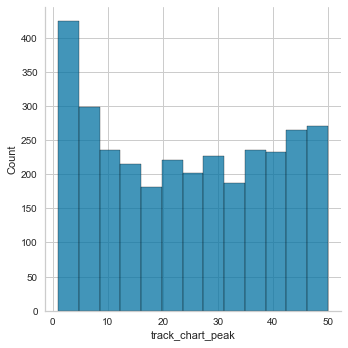

In [3]:
sns.displot(tracks_df["track_chart_peak"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='track_chart_months', ylabel='Density'>

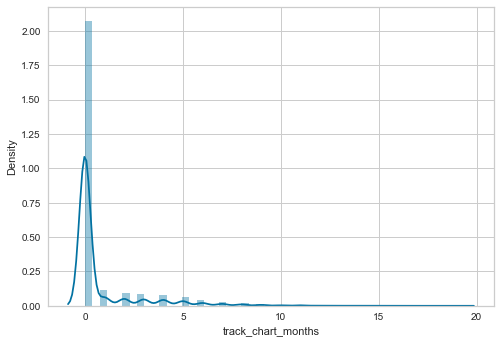

In [4]:
sns.distplot((tracks_df["track_chart_months"]))

In [5]:
print(len(tracks_df[tracks_df["track_chart_months"] > 5]))
print(len(tracks_df[tracks_df["track_chart_months"] > 4]))
print(len(tracks_df[tracks_df["track_chart_months"] > 3]))
print(len(tracks_df[tracks_df["track_chart_months"] > 2]))
print(len(tracks_df[tracks_df["track_chart_months"] > 1]))
print(len(tracks_df[tracks_df["track_chart_months"] == 1]))

671
1035
1498
2000
2545
650


## Audio feature analysis

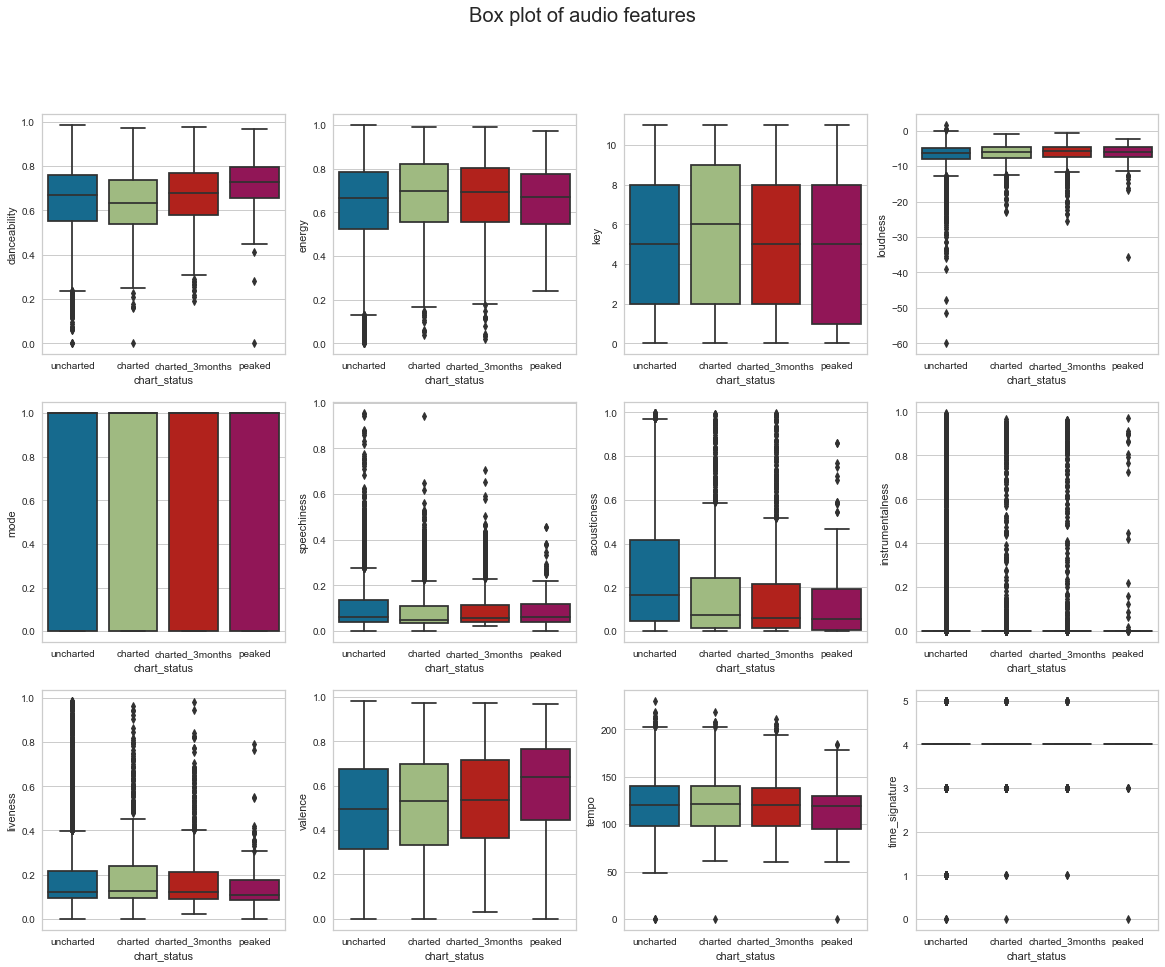

In [6]:
ncols = 4
nrows = int(len(audio_features) / 4)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Box plot of audio features", fontsize=20)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(audio_features):
            break
        sns.boxplot(data=tracks_df, x="chart_status", y=audio_features[idx], ax=axs[row, col],
                    order=["uncharted", "charted", "charted_3months", "peaked"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

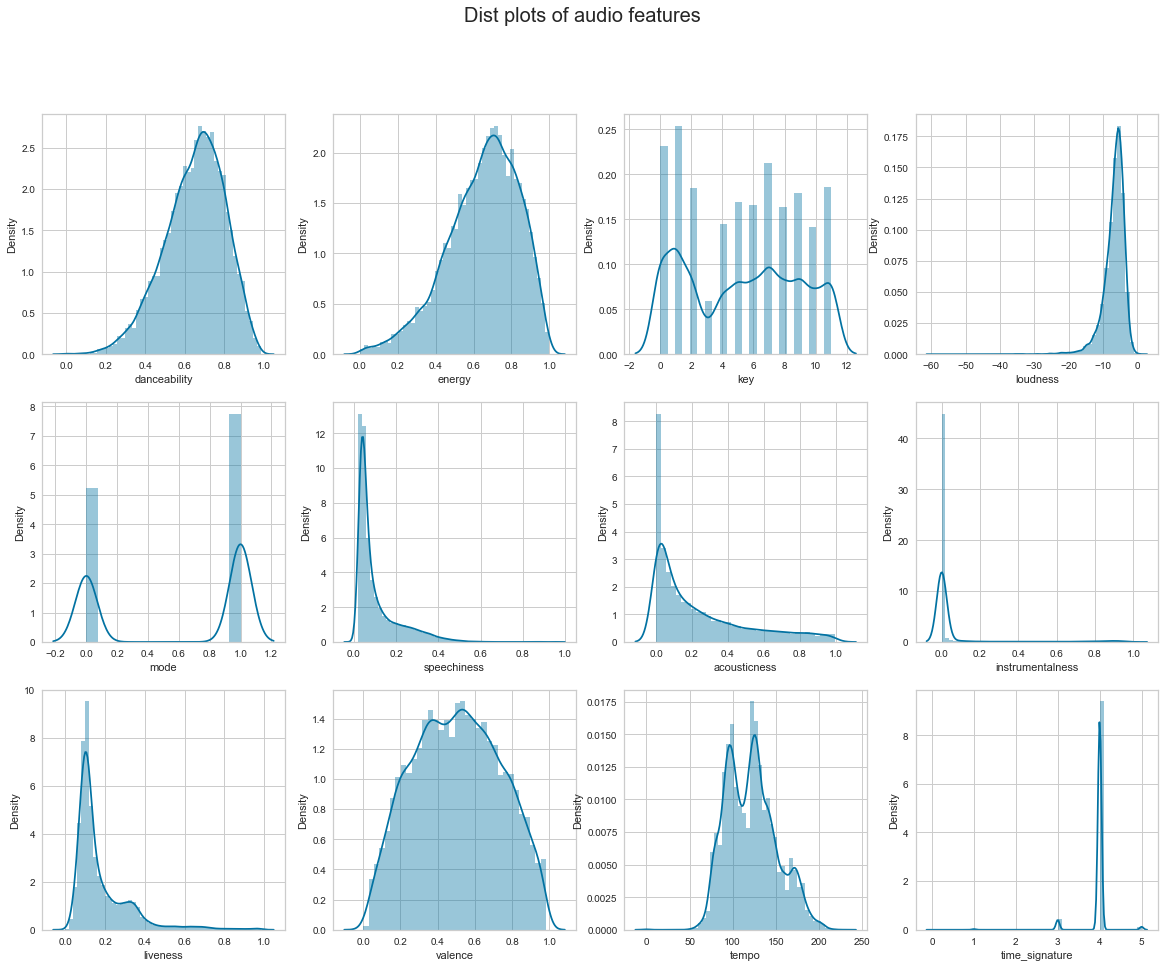

In [7]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Dist plots of audio features", fontsize=20)

ncols = 4
nrows = int(len(audio_features) / 4)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(audio_features):
            break
        sns.distplot(tracks_df[audio_features[idx]], ax=axs[row, col]),
                    #order=["uncharted", "charted", "charted_3months", "peaked"])

<AxesSubplot:xlabel='tempo', ylabel='Density'>

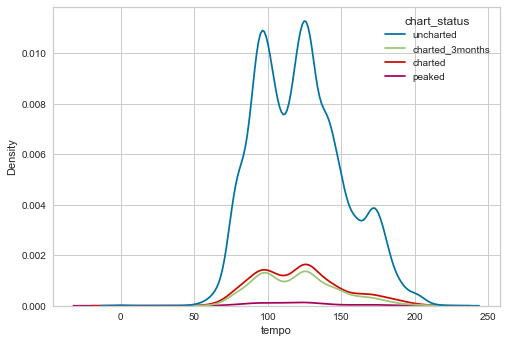

In [8]:
sns.kdeplot(data=tracks_df, x="tempo", hue="chart_status")

## Artist feature analysis

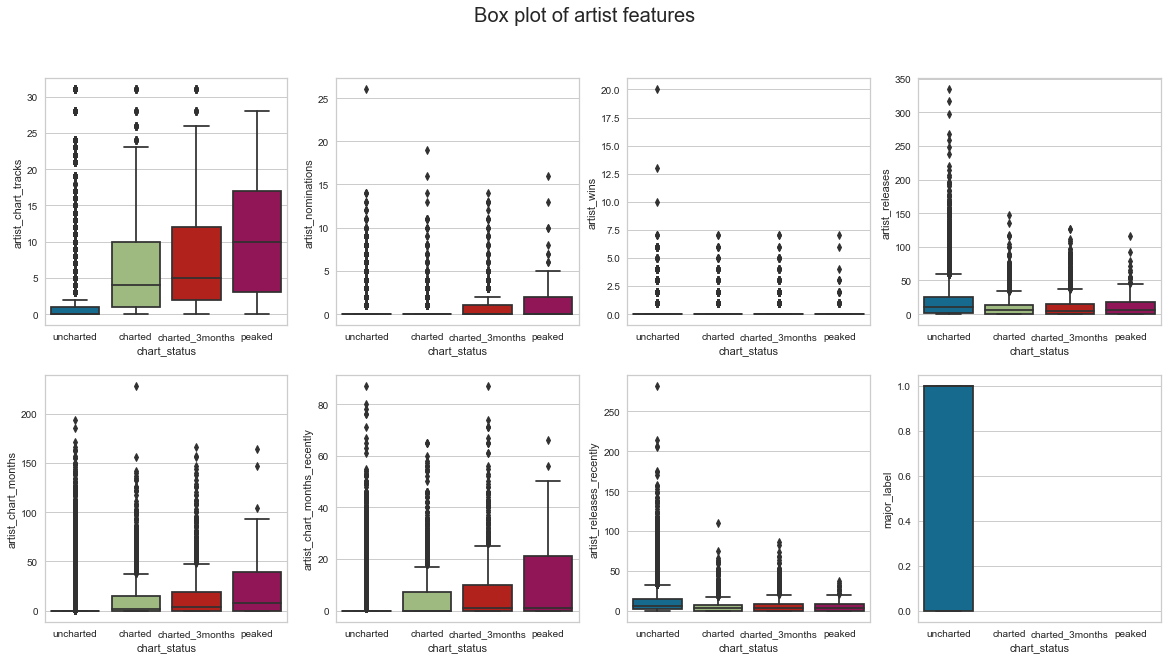

In [9]:
ncols = 4
nrows = int(len(artist_features) / 4)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Box plot of artist features", fontsize=20)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(artist_features):
            break
        sns.boxplot(data=tracks_df, x="chart_status", y=artist_features[idx], ax=axs[row, col],
                    order=["uncharted", "charted", "charted_3months", "peaked"])

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

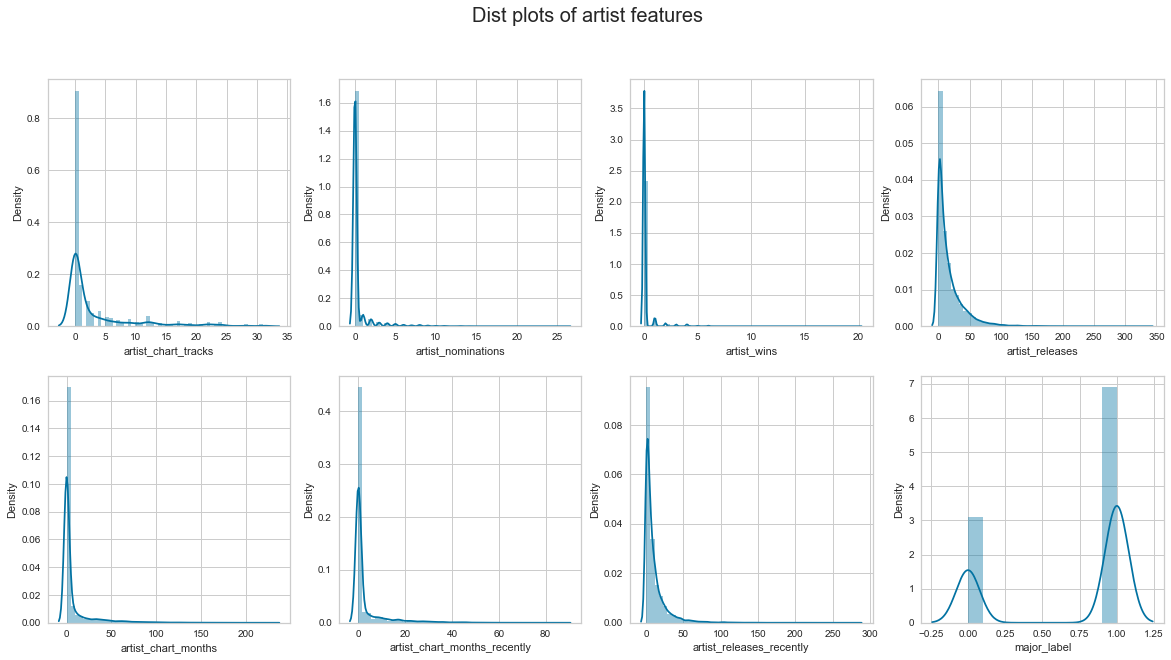

In [10]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
fig.suptitle("Dist plots of artist features", fontsize=20)

ncols = 4
nrows = int(len(artist_features) / 4)

for row in range(nrows):
    for col in range(ncols):
        idx = (row * ncols) + (col + 1) - 1
        if idx > len(artist_features):
            break
        sns.distplot(tracks_df[artist_features[idx]], ax=axs[row, col])

## Revenue Analysis

According to Chart2000: "rough guess is that each unit of Indicative Revenue score represents something like $5,000 of TOTAL revenue generated across the **whole music delivery chain** (in year 2000 dollars). It is reasonable to expect that artists will get at the very most about 10% of this revenue."

In [11]:
df_ = tracks_df.copy()
df_["revenue_est_total"] = df_["track_chart_indicativerevenue"] * 5000.0 / 1000.0
df_["revenue_est_artist"] = df_["revenue_est_total"] * .10
df_["revenue_est_total"].describe()

count     14996.000000
mean       5548.868022
std       15713.359575
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      270898.290000
Name: revenue_est_total, dtype: float64

In [12]:
df_[["artists", "name", "revenue_est_total"]].sort_values(["revenue_est_total"], ascending=False)

,artists,name,revenue_est_total
14520,The Weeknd,Blinding Lights,270898.290
969,Ed Sheeran,Shape of You,164355.470
4177,Lewis Capaldi,Someone You Loved,164177.095
13870,Post Malone,Circles,161989.040
11164,Billie Eilish,bad guy,152528.525
...,...,...,...
5627,The Asteroids Galaxy Tour,Crazy,0.000
5630,Dwayne Johnson,You're Welcome,0.000
5632,Yo Gotti,Down In the DM,0.000
5633,Gleb,Go Go Go,0.000


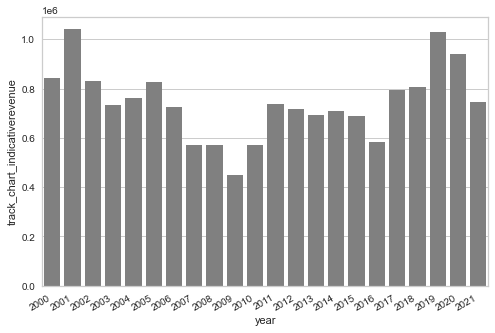

In [13]:
year_revenue = (
    tracks_df
        .groupby("year")
        .aggregate({"track_chart_indicativerevenue": "sum"})
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
plot = sns.barplot(x="year", y="track_chart_indicativerevenue", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

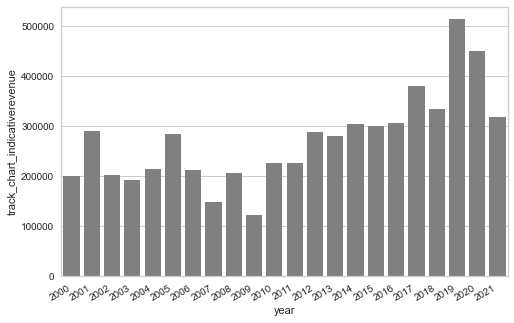

In [14]:
year_revenue = (
    tracks_df
        [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({"track_chart_indicativerevenue": "sum"})
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
plot = sns.barplot(x="year", y="track_chart_indicativerevenue", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

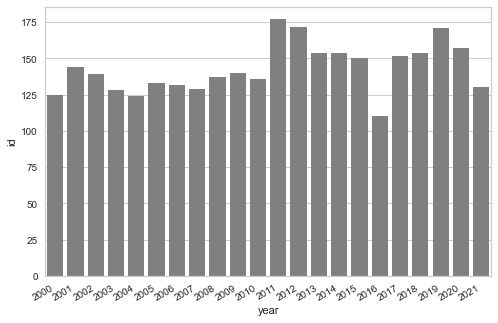

In [15]:
year_count = (
    tracks_df
        [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({"id": "count"})
        .reset_index()
)
year_count = year_count[year_count["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_count, color="gray")
plot.get_figure().autofmt_xdate()

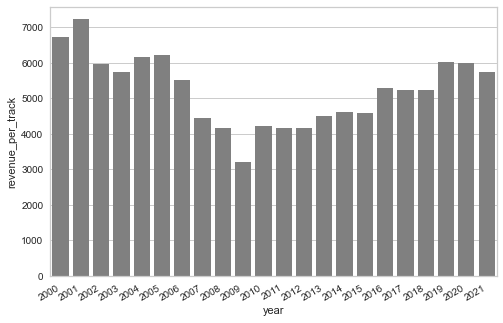

In [16]:
# normalized revenue
year_revenue = (
    tracks_df
        [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({
            "track_chart_indicativerevenue": "sum",
            "id": "count",
        })
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
year_revenue["revenue_per_track"] = year_revenue["track_chart_indicativerevenue"] / year_revenue["id"]
plot = sns.barplot(x="year", y="revenue_per_track", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

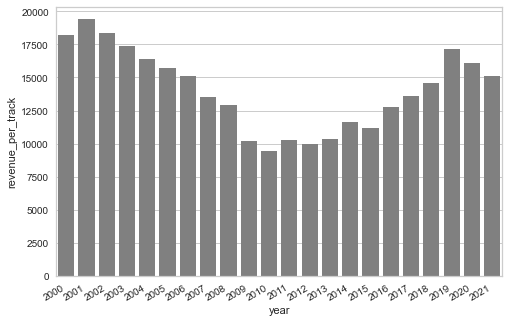

In [17]:
# normalized revenue
year_revenue = (
    tracks_df
    [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({
        "track_chart_indicativerevenue": "sum",
        "id": "count",
    })
        .reset_index()
)
year_revenue = year_revenue[year_revenue["year"] != 2022]
year_revenue["revenue_per_track"] = year_revenue["track_chart_indicativerevenue"] / year_revenue["id"]
plot = sns.barplot(x="year", y="revenue_per_track", data=year_revenue, color="gray")
plot.get_figure().autofmt_xdate()

## Charts Analysis

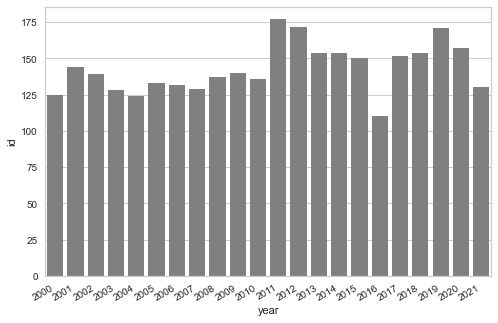

In [18]:
# number of charting songs per year
year_charts = (
    tracks_df
    [tracks_df["track_chart_months"] > 0]
        .groupby("year")
        .aggregate({
            "track_chart_months": "sum",
            "id": "count",
        })
        .reset_index()
)
year_charts = year_charts[year_charts["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_charts, color="gray")
plot.get_figure().autofmt_xdate()

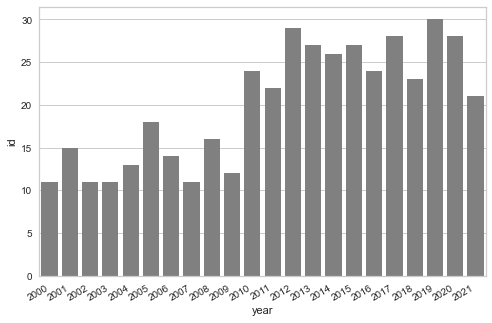

In [19]:
# number of 6+ months charting songs per year
year_charts = (
    tracks_df
    [tracks_df["track_chart_months"] > 6]
        .groupby("year")
        .aggregate({
            "track_chart_months": "sum",
            "id": "count",
    })
    .reset_index()
)
year_charts = year_charts[year_charts["year"] != 2022]
plot = sns.barplot(x="year", y="id", data=year_charts, color="gray")
plot.get_figure().autofmt_xdate()

In [20]:
(
    tracks_df
        [tracks_df["track_chart_months"] > 6]
        .sort_values(["year", "track_chart_months"], ascending=(True, False))
        [["year", "name", "artists", "track_chart_months"]]
)

,year,name,artists,track_chart_months
2500,2000,Hanging By A Moment,Lifehouse,11.0
8362,2000,Kryptonite,3 Doors Down,10.0
8653,2000,In the End,Linkin Park,9.0
9465,2000,I Hope You Dance,Lee Ann Womack,9.0
6228,2000,Bent,Matchbox Twenty,8.0
...,...,...,...,...
959,2022,Castle On the Hill,Ed Sheeran,8.0
7016,2022,I Knew You Were Trouble (Taylor's Version),Taylor Swift,8.0
7936,2022,Telephone - w/o Beyonce,Lady Gaga,8.0
6522,2022,Break My Heart,Dua Lipa,7.0


## Audio feature analysis

/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_27433/3262626429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


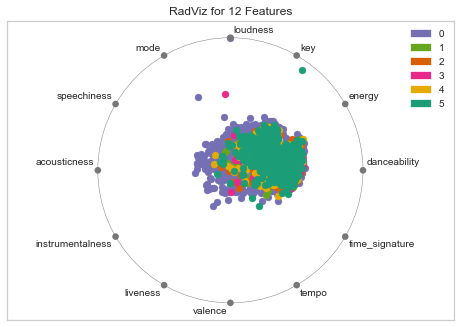

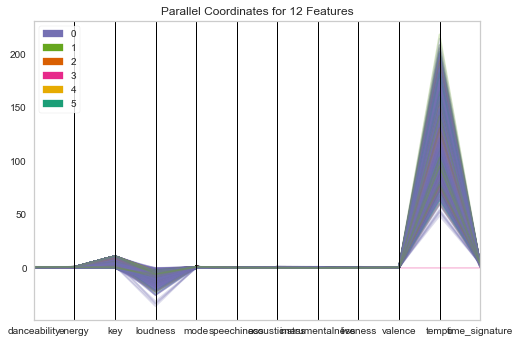

<AxesSubplot:title={'center':'Parallel Coordinates for 12 Features'}>

In [429]:
model_df = tracks_df[audio_features + ["track_chart_months"]]
model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
model_df = model_df.dropna().reset_index(drop=True)
X = model_df.drop(columns=["track_chart_months"]).reset_index(drop=True)
y = model_df["track_chart_months"]

# classes = [0, 1]
classes = [0, 1, 2, 3, 4, 5]
visualizer = RadViz(classes=classes)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

visualizer = ParallelCoordinates(
    classes=classes, features=X.columns, sample=0.25, shuffle=True, random_state=42
)
visualizer.fit_transform(X, y)
visualizer.show()

## Artist feature analysis

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


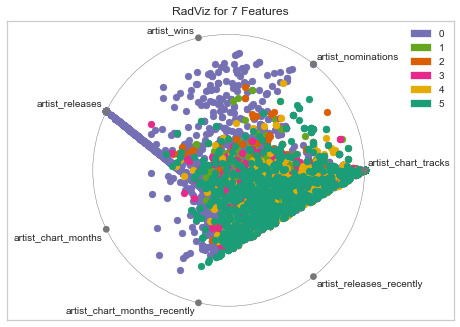

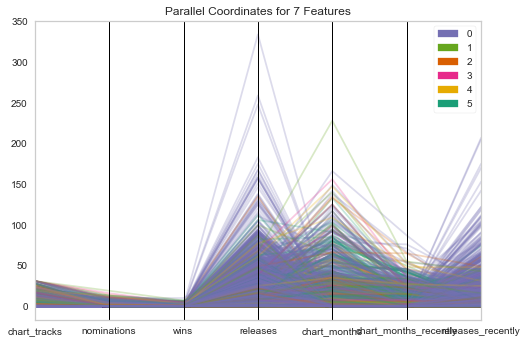

<AxesSubplot:title={'center':'Parallel Coordinates for 7 Features'}>

In [431]:
model_df = tracks_df[artist_features + ["track_chart_months"]].drop(columns="major_label")
model_df["track_chart_months"] = model_df["track_chart_months"].apply(lambda v: 5 if v > 5 else v)
model_df = model_df.dropna().reset_index(drop=True)
X = model_df.drop(columns=["track_chart_months"]).reset_index(drop=True)
y = model_df["track_chart_months"]

# classes = [0, 1]
classes = [0, 1, 2, 3, 4, 5]
visualizer = RadViz(classes=classes)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

feature_names_clean = [col.replace("artist_", "") for col in X.columns]
visualizer = ParallelCoordinates(
    classes=classes, features=feature_names_clean, sample=0.25, shuffle=True, random_state=42
)
visualizer.fit_transform(X, y)
visualizer.show()

## Feature importance

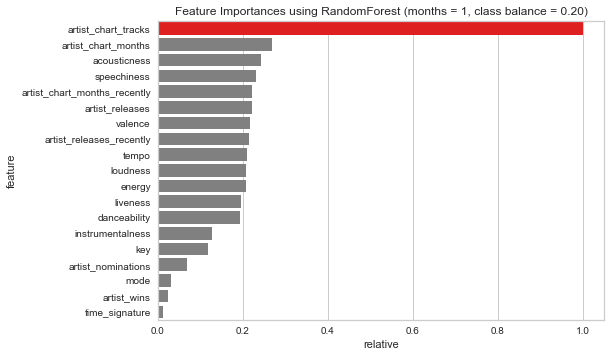

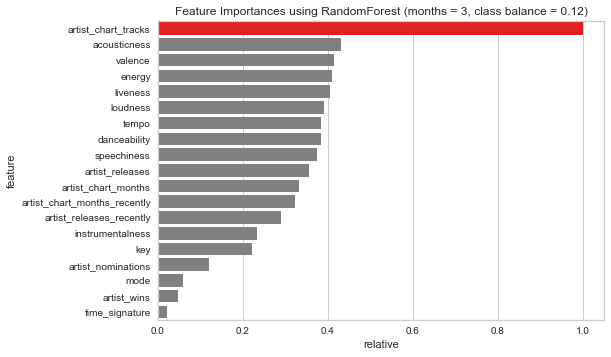

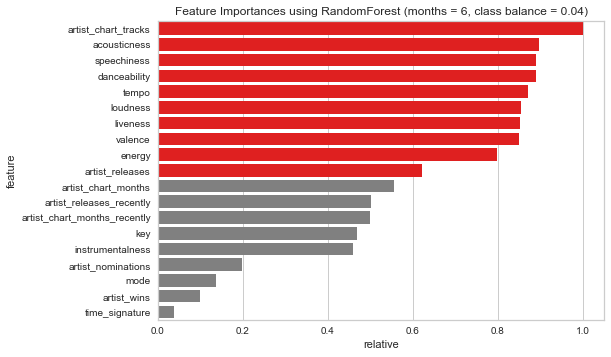

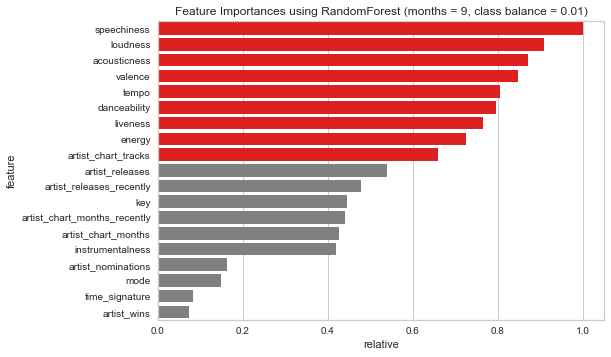

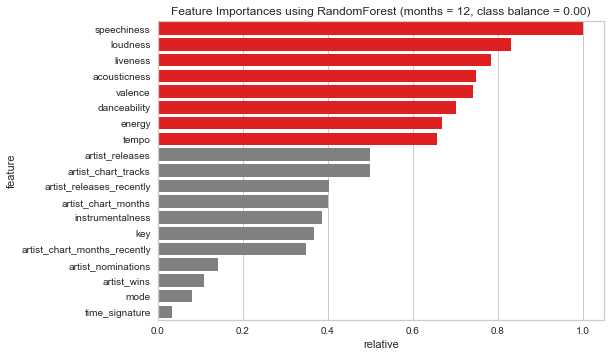

In [432]:
def plot_feature_importance(tracks_df, months, features=audio_features + artist_features):
    X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=features, months=months)
    class_balance = (y_test == 1).sum() / len(y_test)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    feature_importances = pd.DataFrame(
        list(zip(X_train.columns, rf.feature_importances_)),
        columns=["feature", "importance"]
    ).sort_values("importance", ascending=False)
    feature_importances["relative"] = feature_importances["importance"] / np.max(feature_importances["importance"])

    plt.figure()
    g = sns.barplot(x="relative", y="feature", data=feature_importances,
                    palette=np.where(feature_importances["relative"] >= 0.6, "red", "gray"))
    g.set_title(f"Feature Importances using RandomForest (months = {months}, class balance = {class_balance:.2f})")


plot_feature_importance(tracks_df, 1)
plot_feature_importance(tracks_df, 3)
plot_feature_importance(tracks_df, 6)
plot_feature_importance(tracks_df, 9)
plot_feature_importance(tracks_df, 12)

## Feature selection

In [436]:
df_.dropna().shape

(0, 71)

(737, 13)
(737, 13)


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

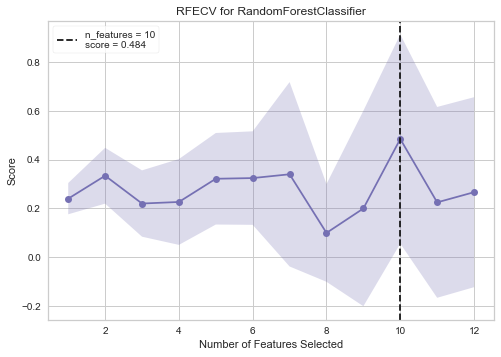

['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


In [438]:
df_ = tracks_df[audio_features + ["track_chart_months"]].sample(frac=0.05).dropna()

X = df_[audio_features]
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_audio_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_audio_features_1_month)

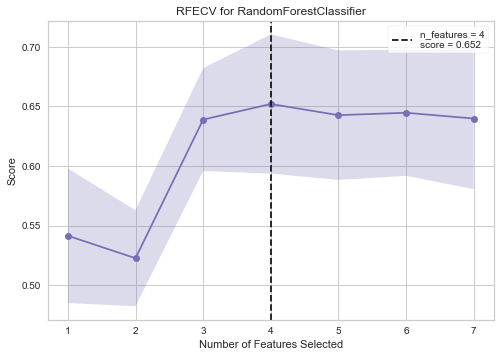

['artist_chart_tracks', 'artist_releases', 'artist_chart_months', 'artist_releases_recently']


In [74]:
df_ = tracks_df.sample(frac=0.05)

X = df_[artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_artist_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_artist_features_1_month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

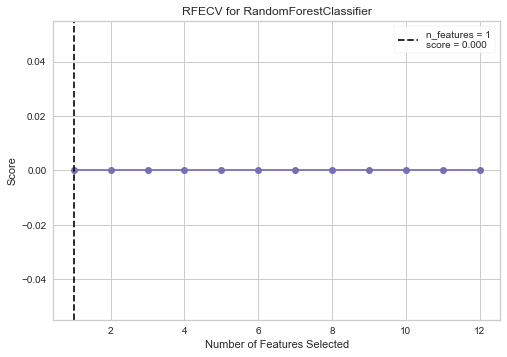

['energy']


In [433]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features]
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_audio_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_audio_features_6_months)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

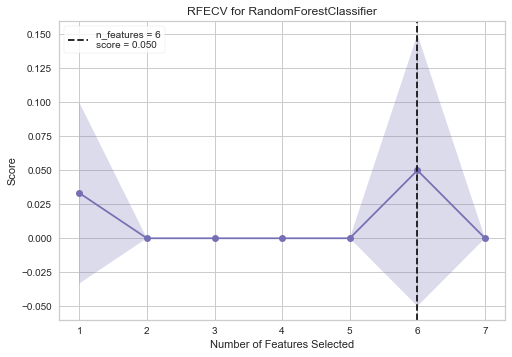

['artist_chart_tracks', 'artist_nominations', 'artist_releases', 'artist_chart_months', 'artist_chart_months_recently', 'artist_releases_recently']


In [76]:
df_ = tracks_df.sample(frac=0.05)

X = df_[artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_artist_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_artist_features_6_months)

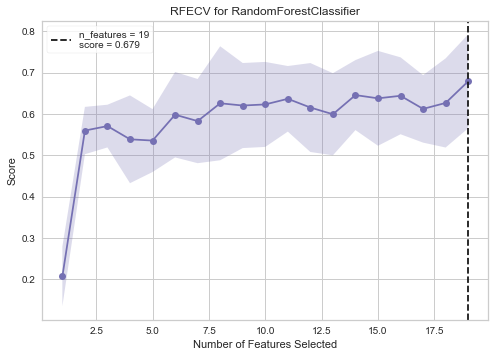

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist_chart_tracks', 'artist_nominations', 'artist_wins', 'artist_releases', 'artist_chart_months', 'artist_chart_months_recently', 'artist_releases_recently']


In [77]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features + artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 1).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_features_1_month = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_features_1_month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

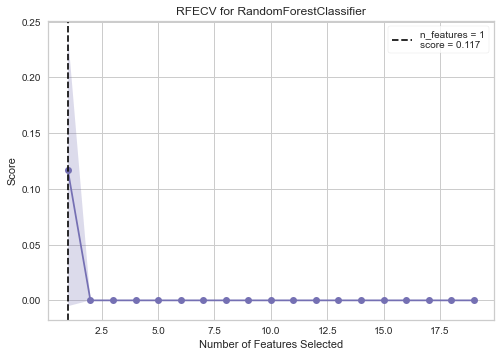

In [65]:
df_ = tracks_df.sample(frac=0.05)

X = df_[audio_features + artist_features].drop(columns="major_label")
y = (df_["track_chart_months"] >= 6).astype(int)

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="precision")
visualizer.fit(X, y)
visualizer.show()

selected_features_6_months = list(visualizer.rfe_estimator_.get_feature_names_out(X.columns))
print(selected_features_6_months)

## Null model

In [56]:
X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=1)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 1 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=6)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 6 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

null score (charted = 1 month): precision=0.78696, f1=0.64876, class size=1278 (21.30%)
null score (charted = 6 month): precision=0.95533, f1=0.91447, class size=268 (4.47%)


## Artist features classification model report (1 month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

train score: accuracy=0.81015, precision=0.55076, f1=0.35989
test score:  accuracy=0.80733, precision=0.54023, f1=0.33176
predicted 1 = 522 (0.09)
actual 1 ...= 1178 (0.20)
actual 1 ...= 282 (0.05)


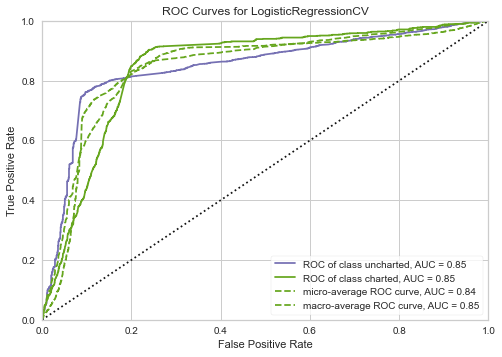

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


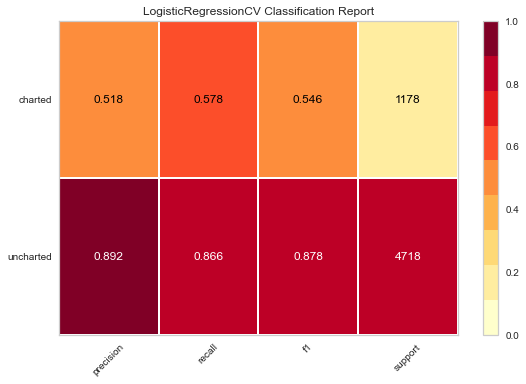

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


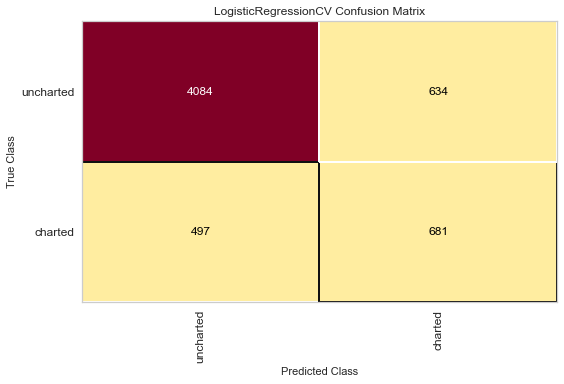

KeyboardInterrupt: 

In [454]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


def create_classification_report(df, features, model, months=1, proba=0.5):

    def scorer(estimator, X, y, *args, **kwargs):
        y_pred_ = (estimator.predict_proba(X)[:,1] >= proba).astype(int)
        return precision_score((y > 0).astype(int), y_pred_)

    X_train, X_test, y_train, y_test = create_test_train_datasets(df, features, months=months)
    model = Pipeline([
        ('scale', StandardScaler()),
        ('lr', LogisticRegressionCV(cv=5, max_iter=1000, class_weight="balanced", scoring=scorer)),
    ])
    model.fit(X_train, y_train)

    # train_score = model.score(X_train, y_train)
    # test_score = model.score(X_test, y_test)
    y_pred_train = (model.predict_proba(X_train)[:,1] >= proba).astype(int)
    y_pred_test = (model.predict_proba(X_test)[:,1] >= proba).astype(int)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)

    print(f"train score: accuracy={train_accuracy:.5f}, precision={train_precision:.5f}, f1={train_f1:.5f}")
    print(f"test score:  accuracy={test_accuracy:.5f}, precision={test_precision:.5f}, f1={test_f1:.5f}")
    print(f"predicted 1 = {(y_pred_test == 1).sum()} ({(y_pred_test == 1).sum() / len(y_pred_test):.2f})")
    print(f"actual 1 ...= {(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_pred_test):.2f})")
    print(f"actual 1 ...= {((y_test == 1) & (y_pred_test == 1)).sum()} ({((y_test == 1) & (y_pred_test == 1)).sum() / len(y_pred_test):.2f})")

    # model = LogisticRegression(multi_class="auto", solver="liblinear")
    visualizer = ROCAUC(model, classes=["uncharted", "charted"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    visualizer = ClassificationReport(model, classes=["uncharted", "charted"], support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    visualizer = ConfusionMatrix(model, classes=["uncharted", "charted"], support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

    visualizer = DiscriminationThreshold(model, exclude=["queue_rate"])
    visualizer.fit(X_test, y_test)
    visualizer.show()

    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    # print(pd.DataFrame(np.exp(model.coef_), columns=X_train.columns).head())
    return model, X_train, X_test, y_train, y_test


lr_artist = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, artist_features, lr_artist, months=1, proba=0.80)

## Artist features classification model report (6 month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

train score: accuracy=0.91712, precision=0.12863, f1=0.14469
test score:  accuracy=0.91723, precision=0.12342, f1=0.13781
predicted 1 = 316 (0.05)
actual 1 ...= 250 (0.04)
actual 1 ...= 39 (0.01)


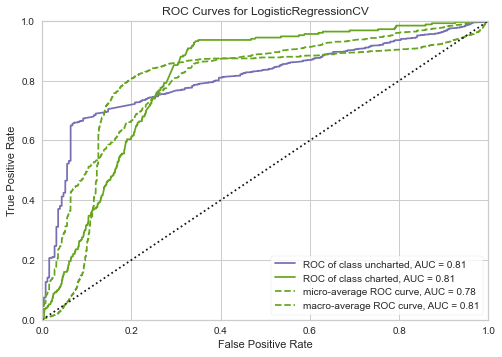

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


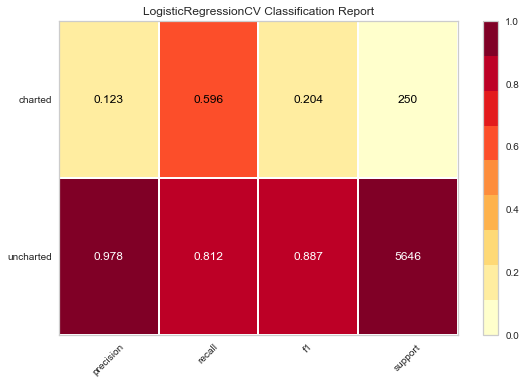

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


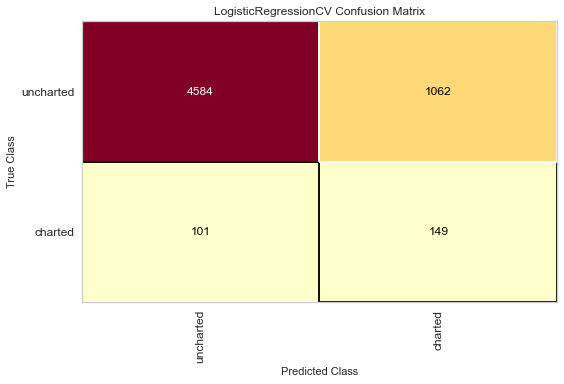

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

KeyboardInterrupt: 

In [440]:
lr_artist = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, artist_features, lr_artist, months=6, proba=0.80)


## Audio features classification model report (1 month)

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

train score: accuracy=0.79701, precision=0.39259, f1=0.05576
test score:  accuracy=0.79715, precision=0.38272, f1=0.04928
predicted 1 = 81 (0.01)
actual 1 ...= 1177 (0.20)
actual 1 ...= 31 (0.01)


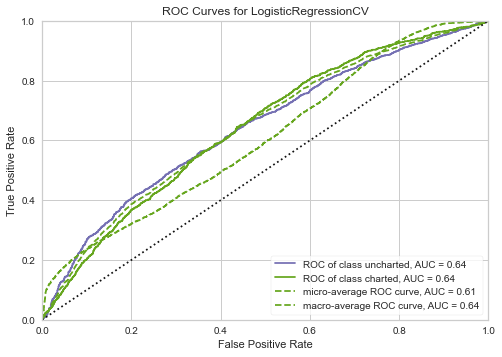

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


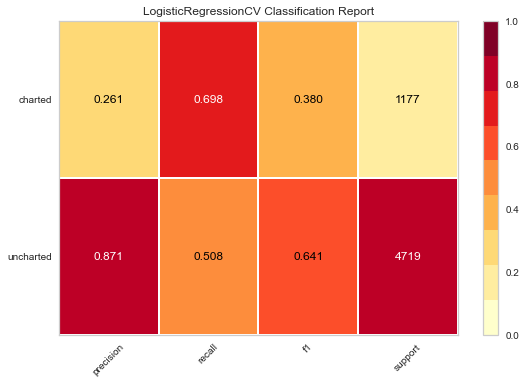

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


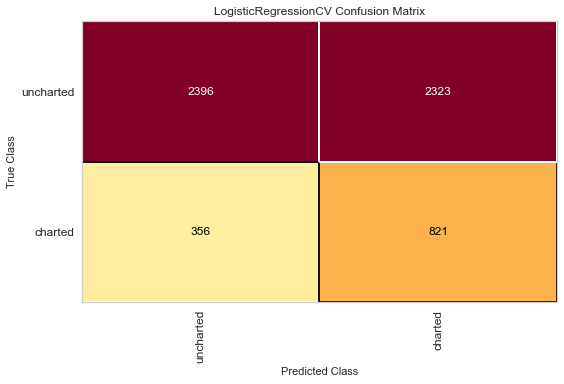

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

KeyboardInterrupt: 

In [441]:
lr_audio_1 = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, audio_features, lr_audio_1, months=1, proba=0.6)

## Audio features classification model report (6 month)

train score: 0.53640, accuracy=0.53640, precision=0.05899, f1=0.10781
test score: 0.52984, accuracy=0.52984, precision=0.05725, f1=0.10476


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


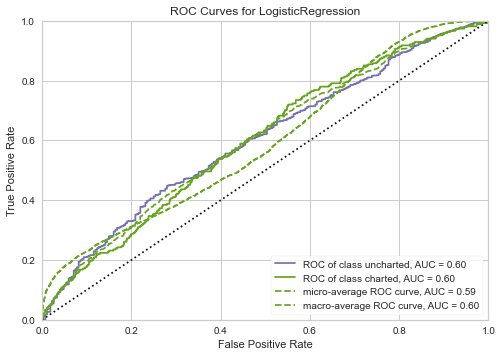

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


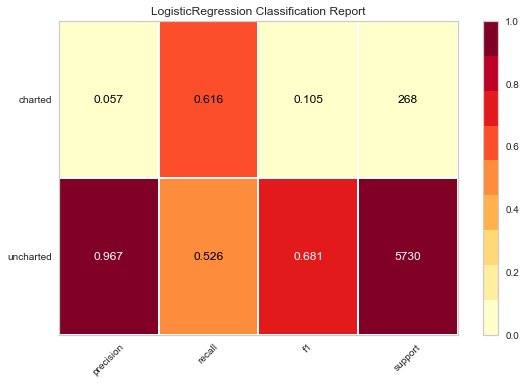

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


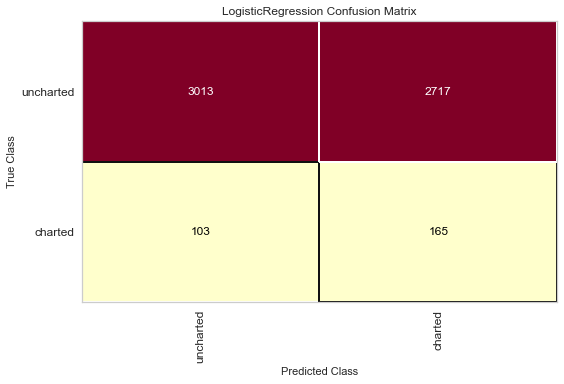

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


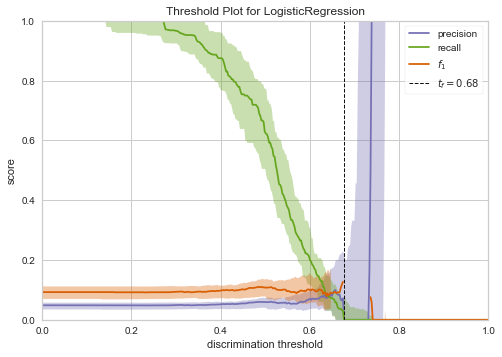

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


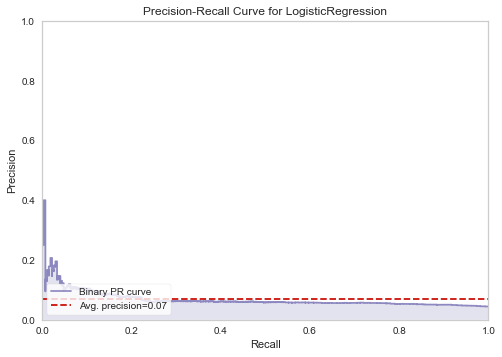

In [293]:
lr_audio_6 = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, audio_features, lr_audio_6, months=6)

In [289]:
artist_features

['artist_chart_tracks',
 'artist_nominations',
 'artist_wins',
 'artist_releases',
 'artist_chart_months',
 'artist_chart_months_recently',
 'artist_releases_recently',
 'major_label']

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

train score: accuracy=0.78944, precision=0.36885, f1=0.12664
test score:  accuracy=0.79054, precision=0.38400, f1=0.13455
predicted 1 = 250 (0.04)
actual 1 ...= 1177 (0.20)
actual 1 ...= 96 (0.02)


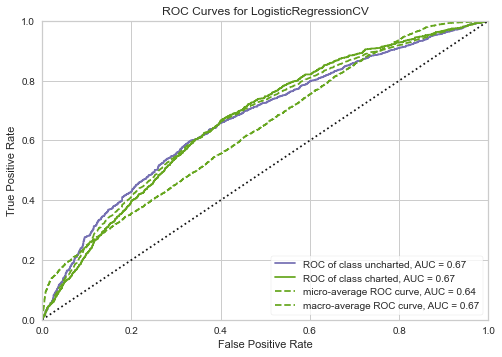

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


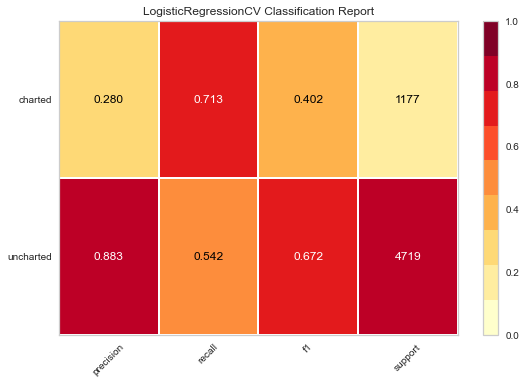

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


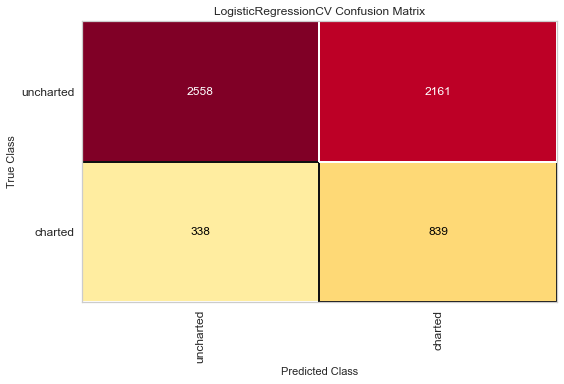

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

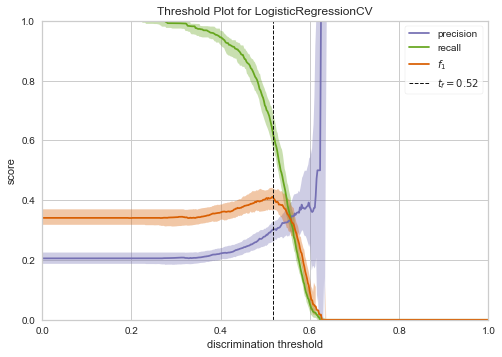

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


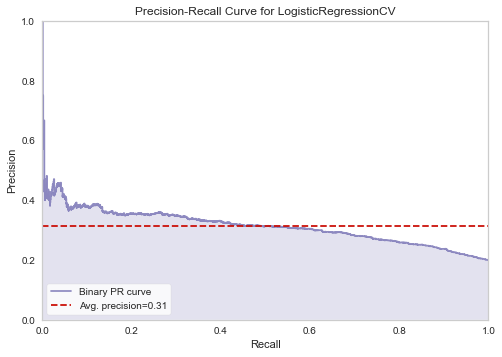

In [455]:
lr_audio_plus_releases = LogisticRegression(max_iter=1000, class_weight="balanced")
selected_features = ["artist_releases"] + audio_features
model, X_train, X_test, y_train, y_test = create_classification_report(tracks_df, selected_features, lr_audio_plus_releases, months=1, proba=0.6)

In [450]:
tracks_df["artist_releases"]

0        39.0
1         1.0
2         8.0
3        32.0
4         1.0
         ... 
14991     5.0
14992     0.0
14993     1.0
14994    20.0
14995     4.0
Name: artist_releases, Length: 14740, dtype: float64

In [467]:
#df_ = tracks_df[selected_features].dropna()
#df_["y"] = (tracks_df["track_chart_months"] > 1).astype(int)
#df_["y_pred"] = (model.predict_proba(df_[selected_features])[:,1] >= 0.60).astype(int)
#df_["y_prob"] = (model.predict_proba(df_[selected_features])[:,1])
#pred_chart = df_[(df_["y_pred"] == 1)]
#tracks_df[tracks_df.index.isin(pred_chart.index)]
#pred_chart
#pred_chart
#tracks_df

#tracks_new_artists_2017 = tracks_df[
#    (tracks_df["year"] == 2017)
#    & (tracks_df["artist_chart_months"] == 0)
    # & (tracks_df["artist_lifetime_chart_months"] >= 1)
    # & (tracks_df["track_chart_months"] >= 1)
#    ]
#tracks_new_artists_2017


df_ = X_test.copy()
df_["y"] = (tracks_df["track_chart_months"] > 1).astype(int)
df_["y_pred"] = (model.predict_proba(X_test)[:,1] >= 0.60).astype(int)
df_["y_prob"] = (model.predict_proba(X_test)[:,1])
pred_chart = df_[(df_["y_pred"] == 1)]
pred_df = pd.merge(tracks_df, pred_chart)[["year", "artists", "name", "y", "y_pred", "y_prob", "artist_chart_months", "artist_lifetime_chart_months"]].sort_values("y_prob", ascending=False)
pred_df = pred_df[(pred_df["year"] >= 2010) & (pred_df["artist_chart_months"] == 0)]
pred_df

,year,artists,name,y,y_pred,y_prob,artist_chart_months,artist_lifetime_chart_months
150,2013,Capital Cities,Safe And Sound,1,1,0.644934,0.0,10.0
95,2018,DJ Opus,Adek Jilbab Ungu - DJ Opus Remix,0,1,0.643565,0.0,0.0
208,2014,Sia,Chandelier,0,1,0.639648,0.0,30.0
23,2012,Calvin Harris,Feel So Close - Radio Edit,1,1,0.639362,0.0,48.0
78,2012,Calvin Harris,Feel So Close - Radio Edit,0,1,0.639359,0.0,48.0
...,...,...,...,...,...,...,...,...
245,2017,Måneskin,Vengo dalla luna,0,1,0.600650,0.0,1.0
159,2020,Joel Corry,Lonely,0,1,0.600646,0.0,3.0
190,2020,JEON SOMI,What You Waiting For,0,1,0.600569,0.0,0.0
54,2021,あたらよ,10月無口な君を忘れる,0,1,0.600381,0.0,0.0


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

train score: accuracy=0.79471, precision=0.54093, f1=0.33055
test score:  accuracy=0.80644, precision=0.59932, f1=0.37815
predicted 1 = 589 (0.10)
actual 1 ...= 1278 (0.21)
actual 1 ...= 353 (0.06)


/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


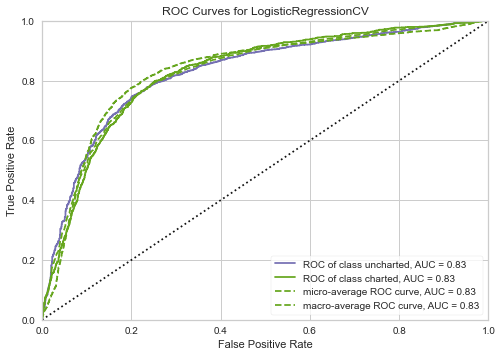

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


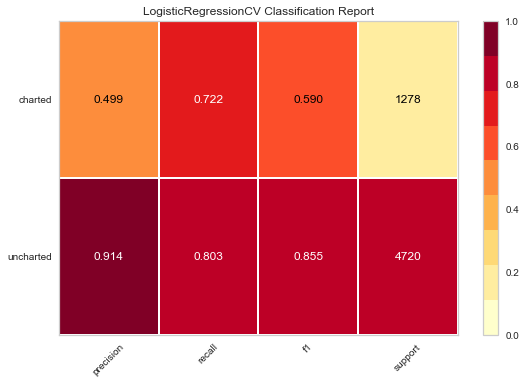

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


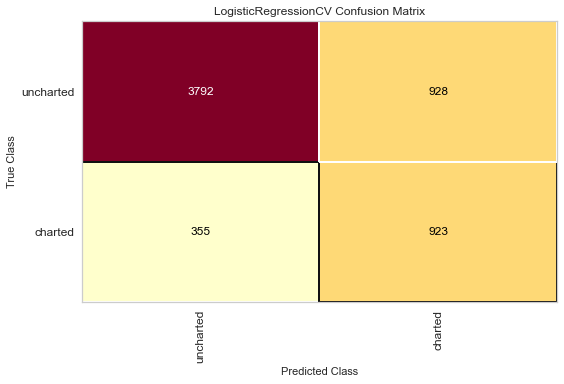

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

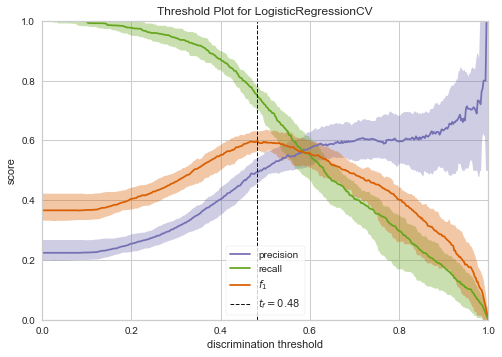

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


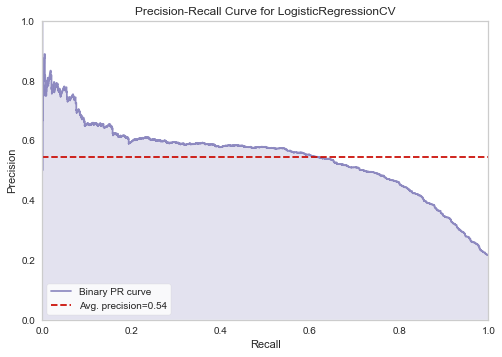

In [344]:
# EVERYTHING
lr_audio_1_everything = LogisticRegression(max_iter=1000, class_weight="balanced")
create_classification_report(tracks_df, artist_features + audio_features, lr_audio_1_everything, months=1, proba=0.8)

## Pairwise distances

In [468]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import pairwise

X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)

distances = pairwise_distances(X_audio_train, X_audio_test)
distances

# d = pd.DataFrame(distances, columns=["distance"], index=X_audio_train.index)
#d["similarity"] =  1 / (d["distance"] / np.max(d["distance"]))
#d["similarity2"] = (d["distance"] / np.max(d["distance"]))
#d["similarity"] = np.where(d["similarity"] == np.inf, 1, d["similarity"])
# d["label"] = y_audio_train
# d.loc[5, :]
#d[d["label"] == 1]["similarity"]
#d["sim_chart"] = d[d["label"] == 1]["distance"].mean() / d[d["label"] == 0]["distance"].mean() >= 1
#d.sort_values("distance")
# d

distances_df = pd.DataFrame(distances, index=X_audio_train.index, columns=X_audio_test.index)

sims = []

for idx, column in distances_df.iteritems():
    # print(idx, column.shape, distances.shape, distances_df.loc[:, idx].shape)
    # print(column.head(20))
    # print(y_audio_train.head(20))
    # print((column * y_audio_train).head(20))
    # print(idx)
    # print((column * y_audio_train).mean())
    # print((column * (1 - y_audio_train)).mean())
    # print((column * y_audio_train).mean() - (column * (1 - y_audio_train)).mean())
    # print(tracks_df.loc[idx, :])
    sims.append({
        "index": idx,
        "1": (column * y_audio_train).mean(),
        "0": ((column * (1 - y_audio_train)).mean()),
        # "D": (column * y_audio_train).mean() - (column * (1 - y_audio_train)).mean(),
    })

sims_df = pd.DataFrame(sims).set_index("index")

In [471]:
sims_df["chart_months"] = y_audio_test
sims_df["pred"] = (sims_df["1"] < sims_df["0"]).astype(int)
#sims_df.loc[61]
(sims_df["pred"] == 1).sum()

5896

In [262]:
(sims_df["pred"] == False).astype(int).sum()

0

In [182]:
d["distance"] / d["distance"].max()

2258     0.080714
8174     0.584289
10524    0.075115
232      0.564097
66       0.341963
           ...   
42       0.581436
11743    0.310687
1829     0.219501
8589     0.199396
12201    0.407446
Name: distance, Length: 8997, dtype: float64

In [280]:
tracks_df.loc[61, :][audio_features]

danceability          0.682
energy                0.503
key                     8.0
loudness             -5.934
mode                    1.0
speechiness          0.0417
acousticness          0.213
instrumentalness        0.0
liveness             0.0944
valence               0.382
tempo               113.988
time_signature          4.0
Name: 61, dtype: object

In [278]:
X_audio_test.loc[61, :]

danceability          0.6820
energy                0.5030
key                   8.0000
loudness             -5.9340
mode                  1.0000
speechiness           0.0417
acousticness          0.2130
instrumentalness      0.0000
liveness              0.0944
valence               0.3820
tempo               113.9880
time_signature        4.0000
Name: 61, dtype: float64

In [279]:
y_audio_test.loc[61]

0

In [277]:
tracks_df.loc[61]

id                   5cpw6QKJcoXzpNBLNUJx2i
name                          Saved My Life
album                         Saved My Life
album_id             1kKYFo3YmUCRmT1tUj31wp
artists                                 Sia
                              ...          
label_matched                           NaN
chart_status                      uncharted
award_status                              0
chart_months                            0.0
has_female_artist                         1
Name: 61, Length: 71, dtype: object

In [188]:
tracks_df[tracks_df["track_chart_months"] == 0]

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,duration_ms,...,artist_chart_months_recently,artist_releases_recently,genre,label_name,major_label,label_matched,chart_status,award_status,chart_months,has_female_artist
0,6stxV2bl7xSiPUornxwyNR,Khapta,En esprit,4YUEcV66XwylhSNJI51ABq,"Heuss L'enfoiré, Sofiane","[""3YwqjMyrRfuixi2pbgTGCE"", ""6qFt3TjvxMt77YGskt...",6,1,True,162906,...,0.0,36.0,rap francais,None,1.0,1.0,uncharted,0,0.0,0
1,62Pp6exz0ywSlBqvNqiY6Z,Anissa,Anissa,5xPYfWKHgxj7jARUJza5eM,Wejdene,"[""1SxuyHZnLUFyFHGzdGaxZk""]",1,1,False,175752,...,0.0,1.0,francoton,None,1.0,1.0,uncharted,0,0.0,1
2,4BS9MBPYKNFEvaC5S7I3fN,Lovesick (feat. Felix Snow),Lovesick (feat. Felix Snow),0QyeR5V23AwRHSgJr1jOvi,Caroline Pennell,"[""0cZPTEmf3mlwj5kjVXR4po"", ""1qskAseW7apRxJBpYA...",1,1,False,234693,...,0.0,8.0,indie poptimism,None,NaN,NaN,uncharted,0,0.0,1
3,09PGubKAMryhOWv1LHpCYz,"fuck, i'm lonely (with Anne-Marie)",~how i'm feeling~,6EgJXcGqaUvgZIF9bqPXfP,"Lauv, Anne-Marie","[""5JZ7CnR6gTvEMKX4g70Amv"", ""1zNqDE7qDGCsyzJwoh...",2,1,True,198973,...,1.0,26.0,uk pop,[no label],0.0,1.0,uncharted,0,0.0,0
4,7IerPeiRJsJfVaPW73GmbS,Bao Tiền Một Mớ Bình Yên,Bao Tiền Một Mớ Bình Yên,3BMJwayvFzLSqYbImGfMnU,"14 Casper, Bon","[""0zo8kCJVktn7oPnzpkbC2p"", ""6hnfLIkvDl6pjlAe1Y...",1,1,False,300000,...,0.0,1.0,viet lo-fi,Viết Tân Studio,0.0,1.0,uncharted,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14990,1sD32hk8V2vR4ME7M0rPT5,Tequila Sunrise,Tequila Sunrise,3l8AkEiLKIulRlcFwY4frk,"Cali Y El Dandee, Rauw Alejandro","[""5DUlefCLzVRzNWaNURTFpK"", ""1mcTU81TzQhprhouKa...",1,1,False,234306,...,0.0,10.0,champeta,None,NaN,NaN,uncharted,0,0.0,0
14992,3Z5asGY62KL6Apsl5a1hRV,Her Yer Karanlık,Her Yer Karanlık,25Y0vuZYhaK2ei8b8GF7nB,Günay Aksoy,"[""42eVTsIe8wg9QTuzYSn4UB""]",1,1,False,208211,...,0.0,0.0,other,MCA Records,1.0,1.0,uncharted,0,0.0,0
14993,1KtNzKnZVIsS3tQ7DlJ8uF,Not Enough,Not Enough,5myXWKCgTfPFRzq2TKENRV,Demo Taped,"[""5JMtXD9vPBIygW4cTcQ8x9""]",1,1,False,202719,...,0.0,1.0,other,None,NaN,NaN,uncharted,0,0.0,0
14994,0S5eBnwtkuFB0TQTlVqW6C,La Tortura,Fijacion Oral,3Sm7gA9q1Cv14i8ZNjgdsh,"Shakira, Alejandro Sanz","[""0EmeFodog0BfCgMzAIvKQp"", ""5sUrlPAHlS9NEirDB8...",3,1,False,212893,...,13.0,4.0,colombian pop,None,NaN,NaN,uncharted,0,0.0,1
